### Random Forest Tree Models

#### Import Statements and Cleaned Dataset Loading

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, make_scorer
df_cleaned = pd.read_csv("./df_cleaned_new2.csv")
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils import resample

#### Defining Features and Train/Test Split

In [7]:
tgt='SalePrice'
X=df_cleaned.drop(columns=[tgt])
y=df_cleaned[tgt]

#Test and Training Sets
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)

#### Baseline RF Model Initialization:

In [8]:
# baseline RF Model with default RF parameters and OOB scoring enabled
baseline_rf = RandomForestRegressor(random_state=42, oob_score=True)
baseline_rf.fit(Xtrain, ytrain)

#Training set predictions and metrics
yp_base_train = baseline_rf.predict(Xtrain)

base_r2_train = r2_score(ytrain, yp_base_train)
base_mse_train=mean_squared_error(ytrain, yp_base_train)

print("Training R^2: ", base_r2_train)
print("Training MSE: ", base_mse_train)

#testing set predictions and metrics (generalization performance)
yp_base_test = baseline_rf.predict(Xtest)
test_r2 = r2_score(ytest, yp_base_test)
test_mse=mean_squared_error(ytest, yp_base_test)

#OOB calc (performance on separate validation set):
base_oob = baseline_rf.oob_score_

print("\n")
print("Testing R^2:", test_r2)
print("Training MSE:", test_mse)
print("\n")
print("OOB Score (R^2): ", base_oob)


Training R^2:  0.9792381170087266
Training MSE:  82666264.20019266


Testing R^2: 0.8753780056214451
Training MSE: 519548418.47999966


OOB Score (R^2):  0.8603751590244703


#### Feature Importance Analysis (Using Bootstraps and CIs):

In [9]:
# Get feature importances using Bootstrapping
n_bootstraps = 1000 #number of iterations 
n_estimators=100

feature_importances=pd.DataFrame(index=range(n_bootstraps), columns=Xtrain.columns)

#boostrapping - at each iter - refits the model (Random Forest) and calculates feature importances
for i in range (n_bootstraps):
    X_resampled, y_resampled = resample(X, y, random_state=i)
    
    #fitting model
    rf=RandomForestRegressor(n_estimators=n_estimators, random_state=i)
    rf.fit(X_resampled, y_resampled)
    
    feature_importances.iloc[i]=pd.Series(rf.feature_importances_, index=X.columns).reindex(Xtrain.columns, fill_value=0)
    feature_importances=feature_importances.fillna(0)

importance_means = feature_importances.mean()
importance_stds = feature_importances.std()
importance_ci_low = feature_importances.quantile(0.025)
importance_ci_high = feature_importances.quantile(0.975)

# Combine into a summary DataFrame
importance_summary = pd.DataFrame({
    'Mean Importance': importance_means,
    'Standard Deviation': importance_stds,
    '95% CI Lower': importance_ci_low,
    '95% CI Upper': importance_ci_high
})
# sorting by mean importance
importance_summary = importance_summary.sort_values(by='Mean Importance', ascending=False)

print(importance_summary.tail(50))

/var/folders/ls/gtsmsnhn6353gdspcyv20jym0000gn/T/ipykernel_4322/1035085229.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  feature_importances=feature_importances.fillna(0)


                      Mean Importance  Standard Deviation  95% CI Lower  \
Condition1_RRAn              0.000041            0.000040  1.687406e-06   
BsmtFinType2_BLQ             0.000041            0.000029  7.742685e-06   
LandContour_Low              0.000041            0.000031  6.362812e-06   
Exterior1st_BrkFace          0.000040            0.000028  7.857668e-06   
GarageCond_None              0.000038            0.000035  6.927985e-06   
Neighborhood_NridgHt         0.000037            0.000023  9.979813e-06   
GarageFinish_None            0.000036            0.000034  7.031523e-06   
GarageQual_None              0.000036            0.000033  6.027352e-06   
BsmtCond_Fa                  0.000036            0.000030  4.450221e-06   
GarageType_None              0.000035            0.000030  6.909927e-06   
HeatingQC_Fa                 0.000035            0.000025  6.732949e-06   
BsmtExposure_None            0.000035            0.000056  1.124083e-06   
LandContour_Bnk          

#### Feature Selection (based on Feature Importance Analysis and Confidence Intervals (CIs)):

Features to remove: ['3SsnPorch', 'BldgType_1Fam', 'BldgType_2fmCon', 'BldgType_Duplex', 'BldgType_Twnhs', 'BldgType_TwnhsE', 'BsmtCond_Fa', 'BsmtCond_Gd', 'BsmtCond_None', 'BsmtCond_TA', 'BsmtExposure_Av', 'BsmtExposure_Gd', 'BsmtExposure_Mn', 'BsmtExposure_No', 'BsmtExposure_None', 'BsmtFinSF2', 'BsmtFinType1_ALQ', 'BsmtFinType1_BLQ', 'BsmtFinType1_GLQ', 'BsmtFinType1_LwQ', 'BsmtFinType1_None', 'BsmtFinType1_Rec', 'BsmtFinType1_Unf', 'BsmtFinType2_ALQ', 'BsmtFinType2_BLQ', 'BsmtFinType2_LwQ', 'BsmtFinType2_None', 'BsmtFinType2_Rec', 'BsmtFinType2_Unf', 'BsmtHalfBath', 'BsmtQual_Ex', 'BsmtQual_Fa', 'BsmtQual_Gd', 'BsmtQual_None', 'BsmtQual_TA', 'CentralAir_N', 'CentralAir_Y', 'Condition1_Artery', 'Condition1_Feedr', 'Condition1_Norm', 'Condition1_PosN', 'Condition1_RRAn', 'Electrical_FuseA', 'Electrical_FuseF', 'Electrical_SBrkr', 'ExterCond_Fa', 'ExterCond_Gd', 'ExterCond_TA', 'ExterQual_Ex', 'ExterQual_Gd', 'ExterQual_TA', 'Exterior1st_AsbShng', 'Exterior1st_BrkFace', 'Exterior1st_C

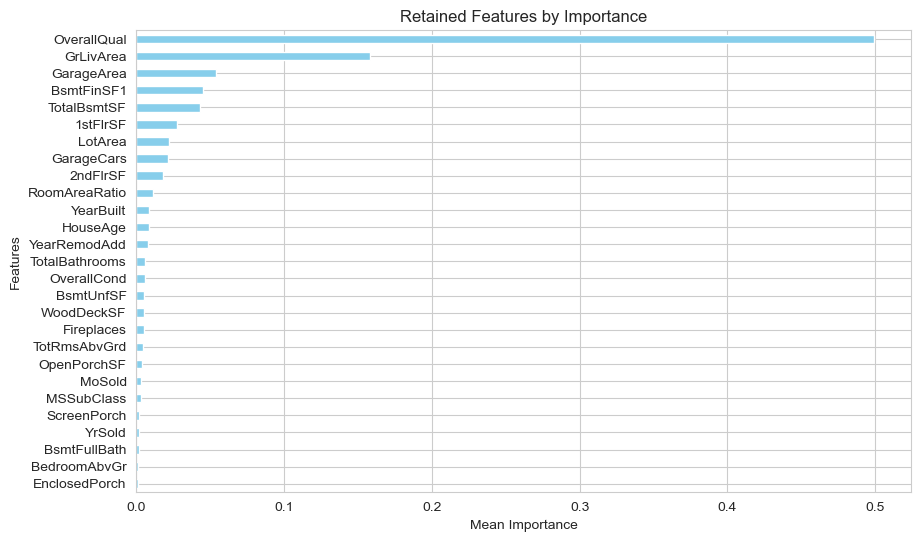

Original CV MSE: -556097599.6942819
Reduced CV MSE: -522010418.7060118


In [10]:
#Threshold Setting
imp_thresh=0.001

# features to keep based on quantile and CI bounds 
features_to_keep = importance_summary[
    (importance_summary['Mean Importance'] > imp_thresh) &
    (importance_summary['95% CI Lower'] > 0)
    ].index

features_to_remove = importance_summary.index.difference(features_to_keep)

print("Features to remove:", features_to_remove.tolist())
print("Number of features to remove:", len(features_to_remove))
print("Number of features to keep:", len(features_to_keep))

#visualizing the retained (kept) features
retained_feat = importance_summary.loc[features_to_keep]
plt.figure(figsize=(10, 6))
retained_feat['Mean Importance'].sort_values().plot(kind='barh', color='skyblue')
plt.title('Retained Features by Importance')
plt.xlabel('Mean Importance')
plt.ylabel('Features')
plt.show()

Xtrain_reduced = Xtrain[features_to_keep]
Xtest_reduced = Xtest[features_to_keep]

#evaluating baseline model with retained features:
reduced_base_rf=RandomForestRegressor(n_estimators=100, random_state=42)
reduced_base_rf.fit(Xtrain_reduced, ytrain)

# comparing performance with full set of features vs reduced features (subset of features)
cv_original = cross_val_score(baseline_rf, Xtrain, ytrain, cv=5, scoring='neg_mean_squared_error')
cv_reduced = cross_val_score(reduced_base_rf, Xtrain_reduced, ytrain, cv=5, scoring='neg_mean_squared_error')

print("Original CV MSE:", cv_original.mean())
print("Reduced CV MSE:", cv_reduced.mean())

#### Hypertuned RF Model (RandomizedSearchCV for Parameter Hypertuning)

In [11]:
#parameter grid - parameters decided based on iterative RandomizedSearchCVs
param_grid = {
    'n_estimators': [600, 800, 1000],  # Number of trees in the forest
    # increasing n_estimators usually improves the model as more trees reduce variance - but higher comp costs

    'max_depth': [10, 12, 14],  # Maximum depth of the decision trees
   #deeper trees capture complex patterns in the data but have the risk of overfitting

    'min_samples_split': [6, 8, 10],  # Minimum samples required to split an internal node
    # Higher values reduce overfitting by forcing more splits on data (simpler trees)

    'min_samples_leaf': [3, 5, 7],  # Minimum samples required at a leaf node

    'max_features': [0.4, 0.5, 'sqrt'],  # Maximum features to consider when looking for a split
    #0.4 and 0.5 test intermediate levels for balance while sqrt is standard for RF Models

    'bootstrap': [True, False]  # Whether to use bootstrapping
    # either uses bootstrapping where each tree gets a subset or just uses the entire dataset
}

# Randomized search CV set up
random_search = RandomizedSearchCV(
    estimator=baseline_rf,
    param_distributions=param_grid,
    n_iter=100,              # Number of parameter settings to sample
    scoring='neg_mean_squared_error', # Using MSE as the scoring metric
    cv=10,                   # 10-fold cross-validation
    n_jobs=-1,
    random_state=42 
)
# fitting model
random_search.fit(Xtrain_reduced, ytrain)

# best RF Model (best parameters found in RandomizedSearch)
best_rf = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)
print("Best CV MSE Score:", -random_search.best_score_)

# Training Set evaluation
y_train_pred = best_rf.predict(Xtrain_reduced)
train_r2 = r2_score(ytrain, y_train_pred)
train_mse = mean_squared_error(ytrain, y_train_pred)
print("Training R²:", train_r2)
print("Training MSE:", train_mse)

# Testing Set evaluation
y_test_pred = best_rf.predict(Xtest_reduced)
test_r2 = r2_score(ytest, y_test_pred)
test_mse = mean_squared_error(ytest, y_test_pred)
print("Testing R²:", test_r2)
print("Testing MSE:", test_mse)

print("OOB Score (R²):", best_rf.oob_score_)


/Users/stephenkinsey/opt/anaconda3/envs/my_new_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
520 fits failed out of a total of 1000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
520 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/stephenkinsey/opt/anaconda3/envs/my_new_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/stephenkinsey/opt/anaconda3/envs/my_new_env/lib/python3.9/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/stephenkinsey/opt/anaconda3/envs/my_new_en

Best Parameters: {'n_estimators': 800, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 0.4, 'max_depth': 12, 'bootstrap': True}
Best CV MSE Score: 518119824.6690699
Training R²: 0.9548569813776754
Training MSE: 179743075.60618958
Testing R²: 0.8870448937039771
Testing MSE: 470909225.35771626
OOB Score (R²): 0.8712546733444454


#### Model Evaluation for Random Forest Models

In [12]:
def adjusted_r2(r2, n, p):
    return 1 - ((1 - r2) * (n - 1) / (n - p - 1))

# base rf model metrics calc
baseline_train_r2 = r2_score(ytrain, baseline_rf.predict(Xtrain))
baseline_test_r2 = r2_score(ytest, baseline_rf.predict(Xtest))
baseline_train_mse = mean_squared_error(ytrain, baseline_rf.predict(Xtrain))
baseline_test_mse = mean_squared_error(ytest, baseline_rf.predict(Xtest))
baseline_oob_r2 = baseline_rf.oob_score_

# adj r2
baseline_train_adj_r2 = adjusted_r2(baseline_train_r2, Xtrain.shape[0], Xtrain.shape[1])
baseline_test_adj_r2 = adjusted_r2(baseline_test_r2, Xtest.shape[0], Xtrain.shape[1])

# hypertuned param RF Model
hypertuned_train_r2 = train_r2  # From earlier hypertuned RF code
hypertuned_test_r2 = test_r2    # From earlier hypertuned RF code
hypertuned_train_mse = train_mse
hypertuned_test_mse = test_mse
hypertuned_oob_r2 = best_rf.oob_score_

# Adj r2
hypertuned_train_adj_r2 = adjusted_r2(hypertuned_train_r2, Xtrain_reduced.shape[0], Xtrain_reduced.shape[1])
hypertuned_test_adj_r2 = adjusted_r2(hypertuned_test_r2, Xtest_reduced.shape[0], Xtrain_reduced.shape[1])

#dataframe to compare the metrics
rf_comp_df = pd.DataFrame({
    "Model": ["Baseline RF", "Hypertuned RF"],
    "Train R²": [baseline_train_r2, hypertuned_train_r2],
    "Test R²": [baseline_test_r2, hypertuned_test_r2],
    "OOB R²": [baseline_oob_r2, hypertuned_oob_r2],
    "Train MSE": [baseline_train_mse, hypertuned_train_mse],
    "Test MSE": [baseline_test_mse, hypertuned_test_mse],
    "Adjusted Train R²": [baseline_train_adj_r2, hypertuned_train_adj_r2],
    "Adjusted Test R²": [baseline_test_adj_r2, hypertuned_test_adj_r2]
})

print(rf_comp_df)

           Model  Train R²   Test R²    OOB R²     Train MSE      Test MSE  \
0    Baseline RF  0.979238  0.875378  0.860375  8.266626e+07  5.195484e+08   
1  Hypertuned RF  0.954857  0.887045  0.871255  1.797431e+08  4.709092e+08   

   Adjusted Train R²  Adjusted Test R²  
0           0.975187          0.641394  
1           0.953749          0.875085  


#### Visualization of Random Forest Models' Performance

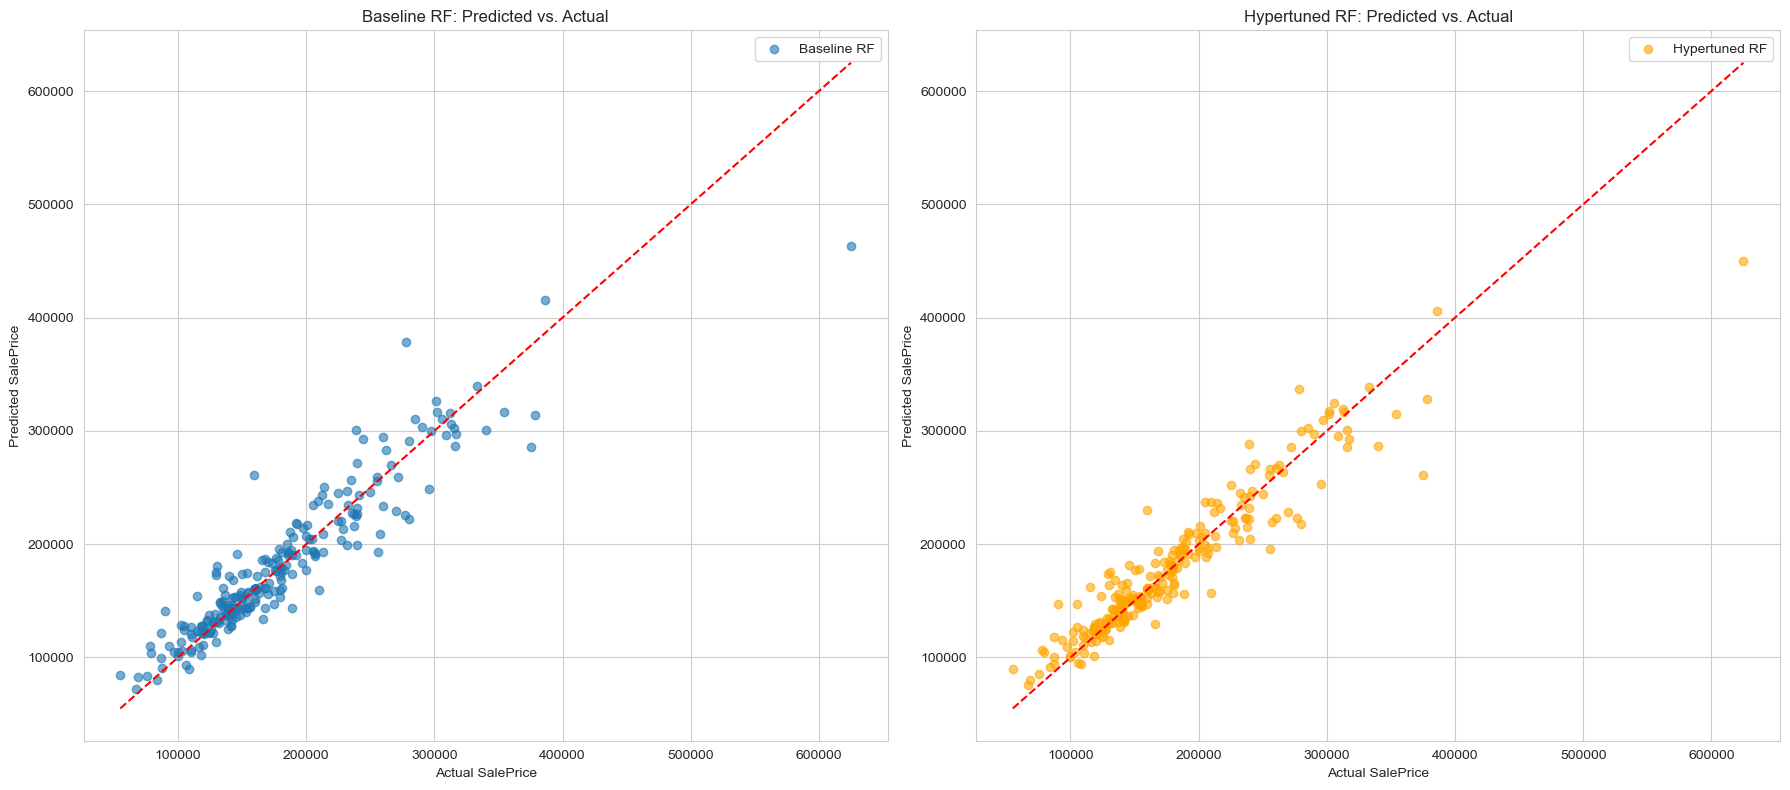

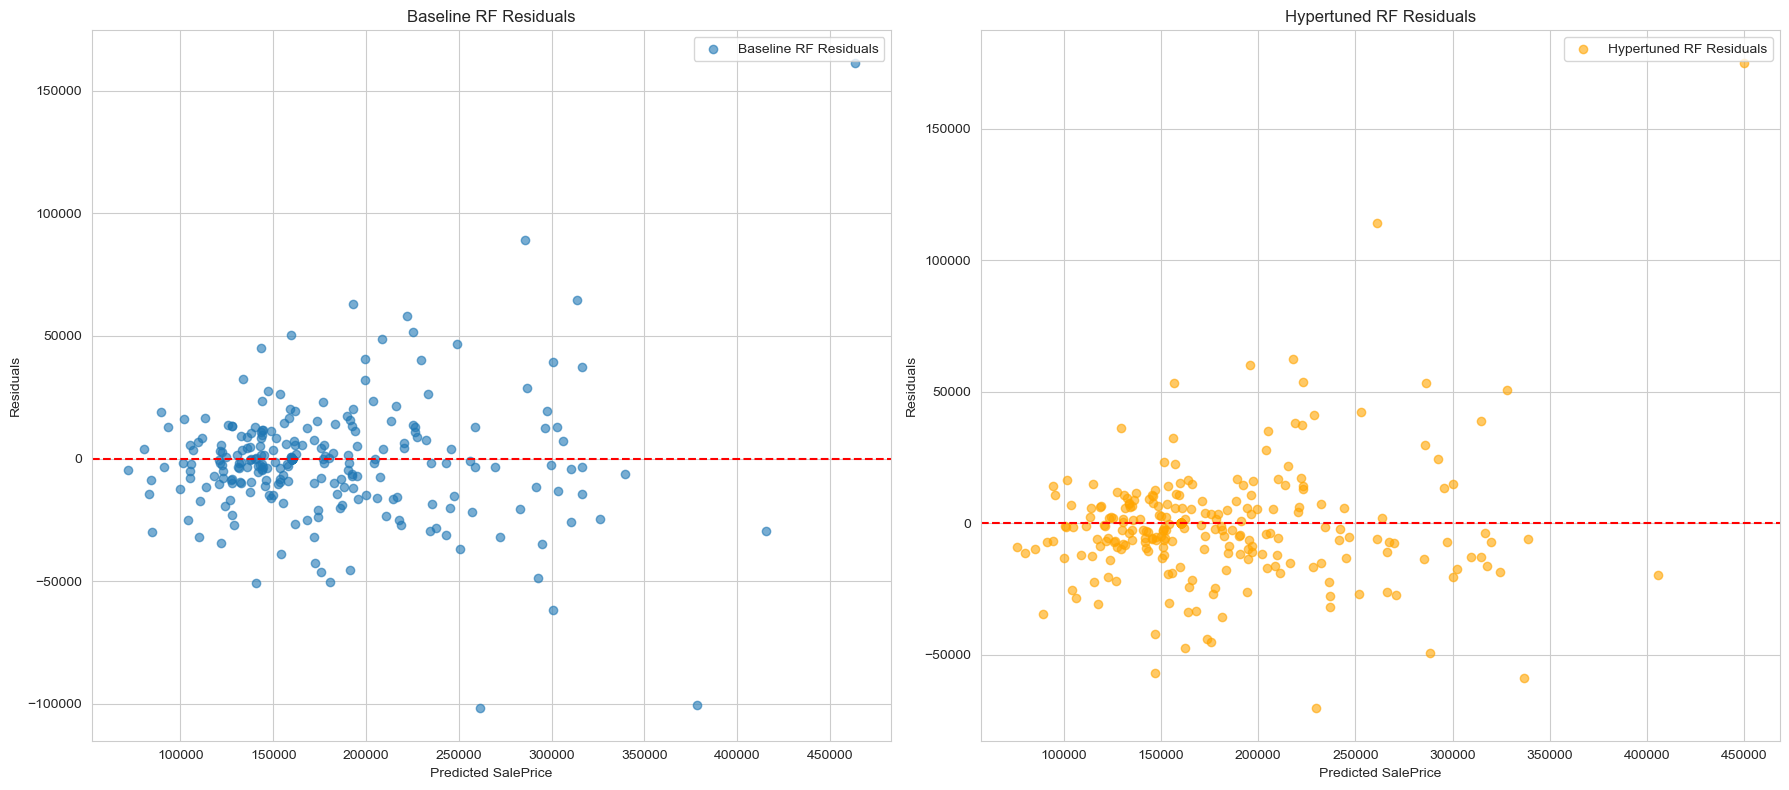

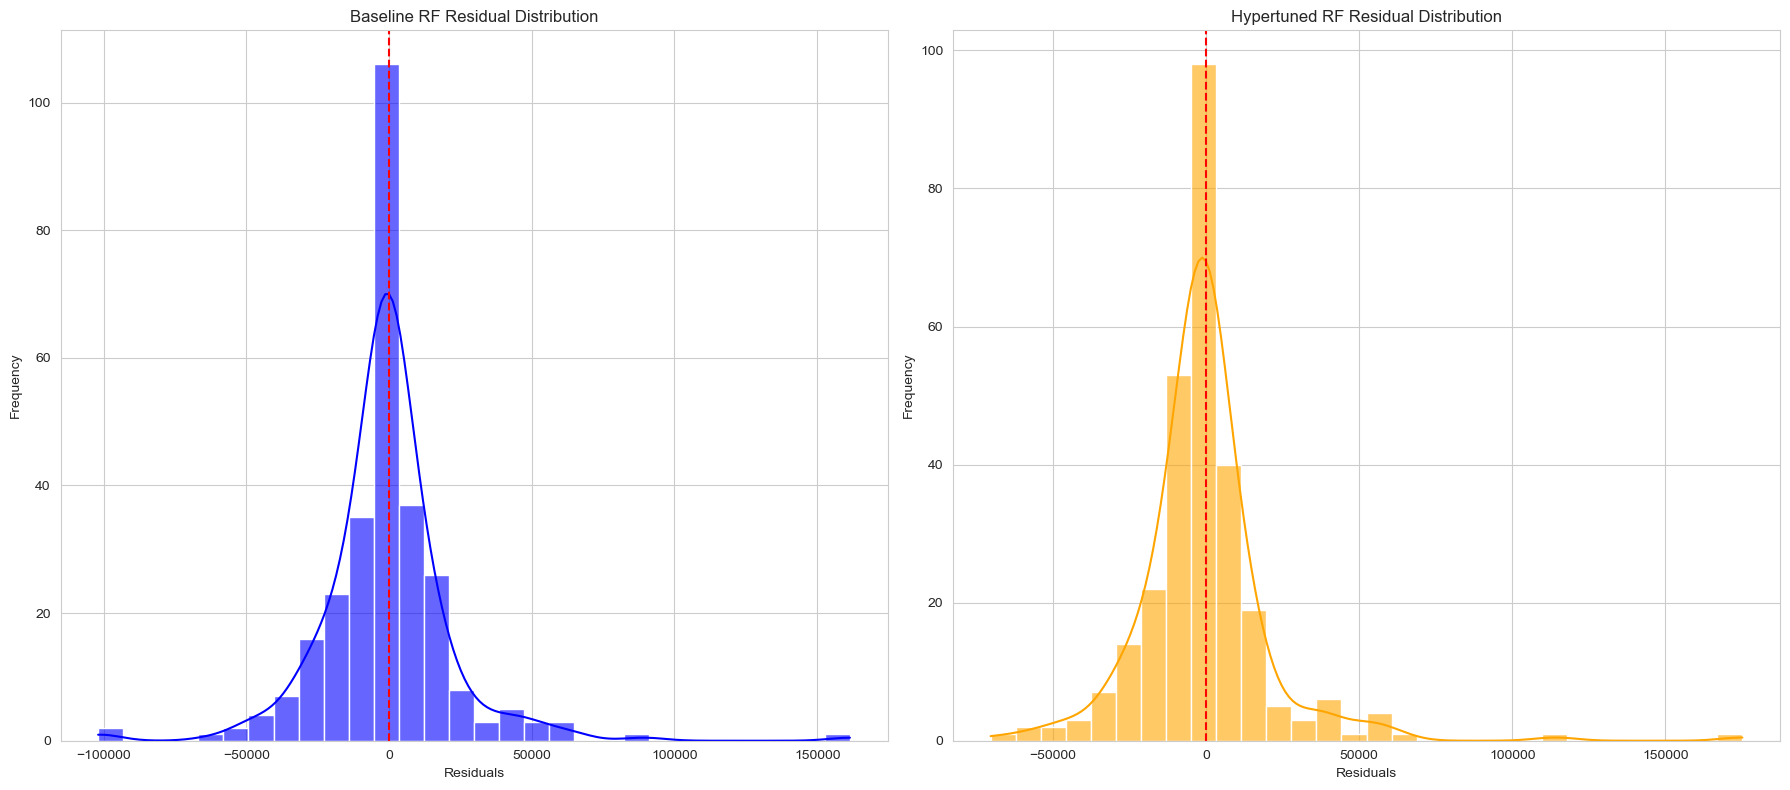

In [13]:
# plot 1 - actual vs predicted values (both models)
plt.figure(figsize=(18, 8))

# Baseline RF plot 1
plt.subplot(1, 2, 1)
baseline_pred = baseline_rf.predict(Xtest)
plt.scatter(ytest, baseline_pred, alpha=0.6, label='Baseline RF')
plt.plot([ytest.min(), ytest.max()], [ytest.min(), ytest.max()], color='red', linestyle='--')
plt.title("Baseline RF: Predicted vs. Actual")
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.legend()

# Hypertuned RF plot 1
plt.subplot(1, 2, 2)
hypertuned_pred = best_rf.predict(Xtest_reduced)
plt.scatter(ytest, hypertuned_pred, alpha=0.6, label='Hypertuned RF', color='orange')
plt.plot([ytest.min(), ytest.max()], [ytest.min(), ytest.max()], color='red', linestyle='--')
plt.title("Hypertuned RF: Predicted vs. Actual")
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.legend()

plt.tight_layout()
plt.show()

# plot 2 - residual plot analysis
plt.figure(figsize=(18, 8))

# Baseline RF residuals 
plt.subplot(1, 2, 1)
baseline_residuals = ytest - baseline_pred
plt.scatter(baseline_pred, baseline_residuals, alpha=0.6, label='Baseline RF Residuals')
plt.axhline(0, color='red', linestyle='--')
plt.title("Baseline RF Residuals")
plt.xlabel("Predicted SalePrice")
plt.ylabel("Residuals")
plt.legend()

# Hypertuned RF residuals 
plt.subplot(1, 2, 2)
hypertuned_residuals = ytest - hypertuned_pred
plt.scatter(hypertuned_pred, hypertuned_residuals, alpha=0.6, label='Hypertuned RF Residuals', color='orange')
plt.axhline(0, color='red', linestyle='--')
plt.title("Hypertuned RF Residuals")
plt.xlabel("Predicted SalePrice")
plt.ylabel("Residuals")
plt.legend()

plt.tight_layout()
plt.show()

# plot 3 - residuals histogram
plt.figure(figsize=(18, 8))

# Baseline RF Residual Distribution
plt.subplot(1, 2, 1)
sns.histplot(baseline_residuals, kde=True, bins=30, color='blue', alpha=0.6)
plt.axvline(0, color='red', linestyle='--')
plt.title("Baseline RF Residual Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")

# Hypertuned RF Residual Distribution
plt.subplot(1, 2, 2)
sns.histplot(hypertuned_residuals, kde=True, bins=30, color='orange', alpha=0.6)
plt.axvline(0, color='red', linestyle='--')
plt.title("Hypertuned RF Residual Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# Feature Importance Visualization for Hypertuned RF
importances = best_rf.feature_importances_
feature_importances = pd.Series(importances, index=Xtrain_reduced.columns).sort_values(ascending=False)

#### Final Random Forest Model (Hypertuned Params with RandomizedSearchCV)

In [14]:
final_rf_params = {
    "Best Parameters": random_search.best_params_,
    "Best CV MSE Score": -random_search.best_score_,
    "Training R²": train_r2,
    "Training MSE": train_mse,
    "Testing R²": test_r2,
    "Testing MSE": test_mse,
    "OOB R²": best_rf.oob_score_
}

print("Final Random Forest Model (Params):")
for key, value in final_rf_params.items():
    print(f"{key}: {value}")

Final Random Forest Model (Params):
Best Parameters: {'n_estimators': 800, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 0.4, 'max_depth': 12, 'bootstrap': True}
Best CV MSE Score: 518119824.6690699
Training R²: 0.9548569813776754
Training MSE: 179743075.60618958
Testing R²: 0.8870448937039771
Testing MSE: 470909225.35771626
OOB R²: 0.8712546733444454


#### Performance Visualizations for Final Random Forest Model

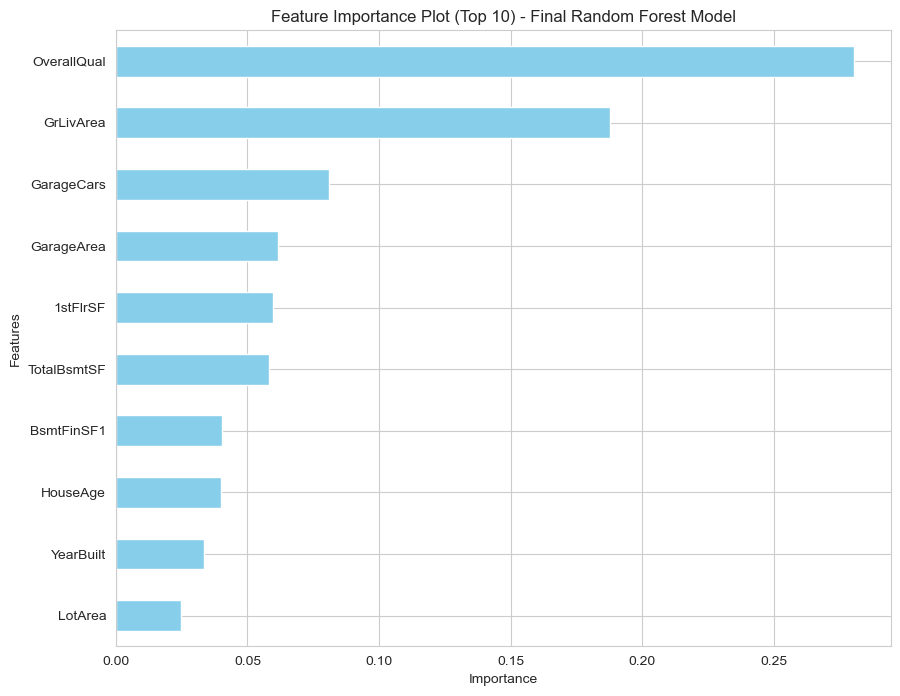

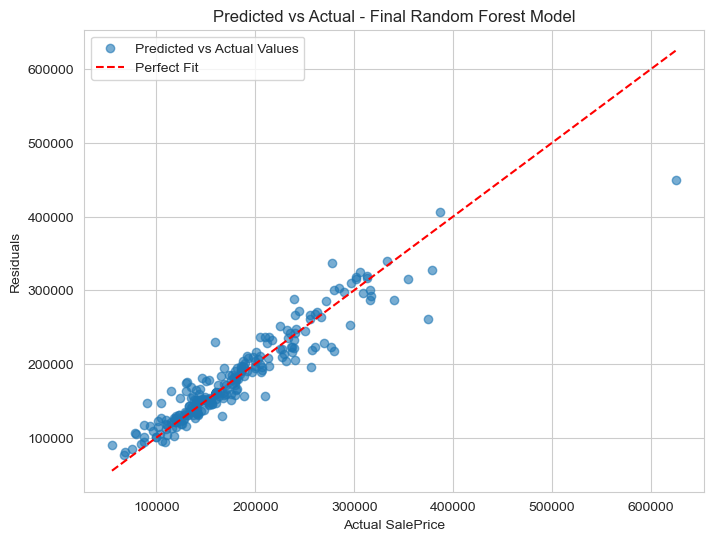

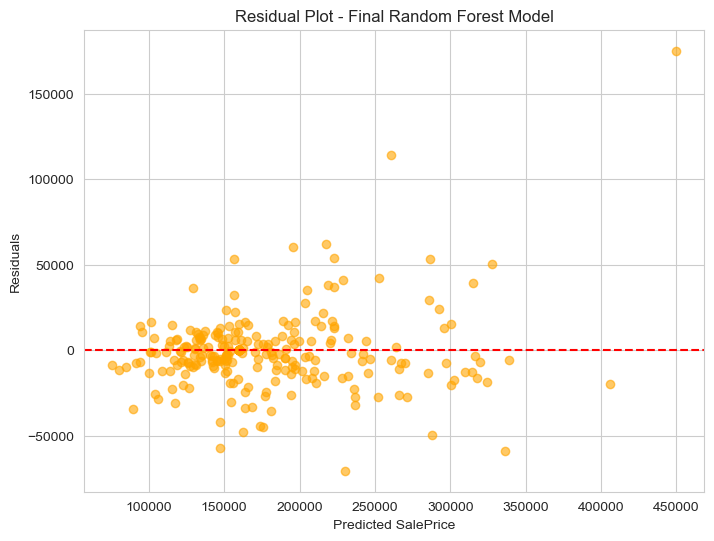

/Users/stephenkinsey/opt/anaconda3/envs/my_new_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


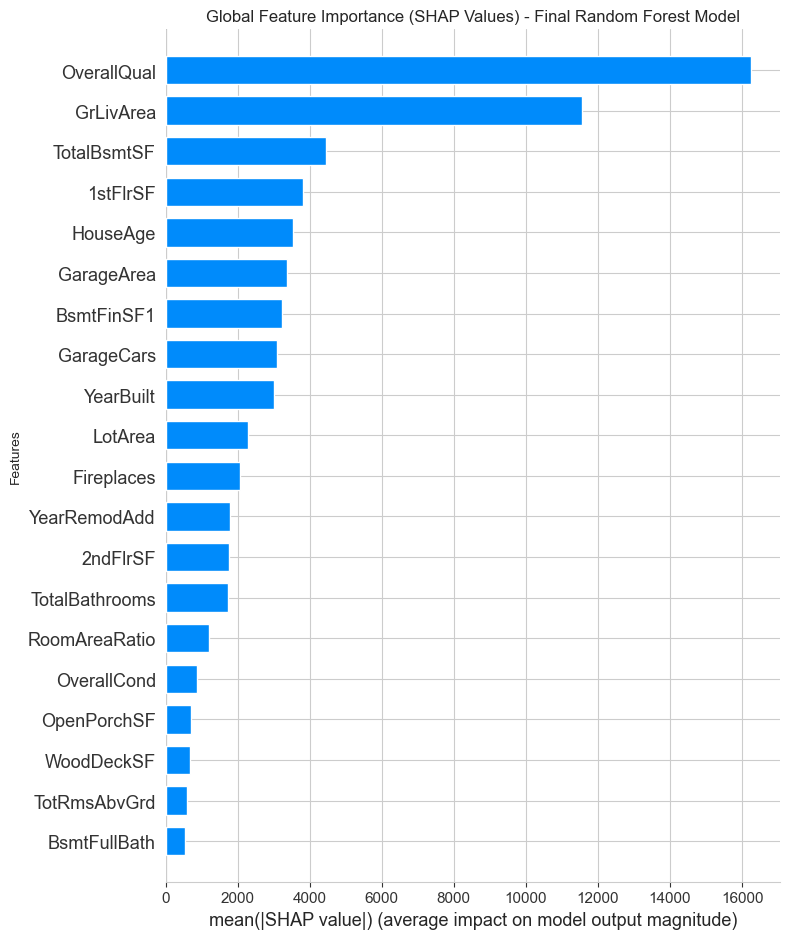

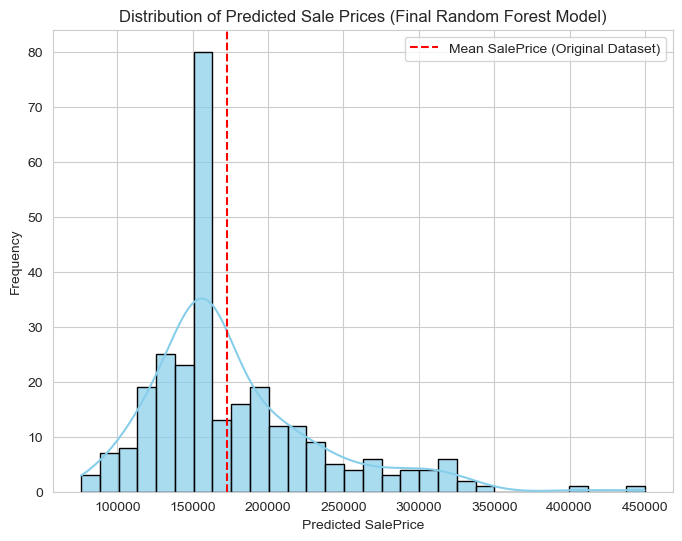

In [15]:
rf_yp_test = best_rf.predict(Xtest_reduced)
rf_res = ytest - rf_yp_test

# Top 10 most important features
plt.figure(figsize=(10, 8))
feature_importances.head(10).plot(kind='barh', color='skyblue')
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Feature Importance Plot (Top 10) - Final Random Forest Model")
plt.gca().invert_yaxis()
plt.show()

#predicted vs actual plot
plt.figure(figsize=(8, 6))
plt.scatter(ytest, rf_yp_test, alpha=0.6, label='Predicted vs Actual Values')
plt.plot([ytest.min(), ytest.max()], [ytest.min(), ytest.max()], 'r--', label="Perfect Fit")
plt.xlabel("Actual SalePrice")
plt.title("Predicted vs Actual - Final Random Forest Model")
plt.ylabel("Residuals")
plt.legend()
plt.show()

#res plot
plt.figure(figsize=(8, 6))
plt.scatter(rf_yp_test, rf_res, alpha=0.6, color='orange')
plt.axhline(0, color='red', linestyle='--')
plt.title("Residual Plot - Final Random Forest Model")
plt.xlabel("Predicted SalePrice")
plt.ylabel("Residuals")
plt.show()

#shap plot:
import shap
explainer_rf = shap.TreeExplainer(best_rf)  # TreeExplainer specific for tree-based models
shap_values_rf = explainer_rf.shap_values(Xtest_reduced)

plt.figure(figsize=(8, 6))
plt.title("Global Feature Importance (SHAP Values) - Final Random Forest Model")
plt.xlabel("Mean Absolute SHAP Value (Impact on Model Output)")
plt.ylabel("Features")
shap.summary_plot(shap_values_rf, Xtest_reduced, plot_type="bar")

# Histogram of Predicted Values
plt.figure(figsize=(8, 6))
sns.histplot(rf_yp_test, kde=True, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Distribution of Predicted Sale Prices (Final Random Forest Model)")
plt.xlabel("Predicted SalePrice")
plt.ylabel("Frequency")
plt.axvline(df_cleaned['SalePrice'].mean(), color='red', linestyle='--', label='Mean SalePrice (Original Dataset)')
plt.legend()
plt.show()